In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ====================
# 1. Определение модели U-Net
# ====================
class SimpleUnet(nn.Module):
    """Упрощенный U-Net для предсказания шума."""
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(), # Downsample
        )
        self.middle = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1), nn.ReLU(), # Upsample
            nn.Conv2d(16, 1, 3, padding=1),
        )

    def forward(self, x, t):
        # x: зашумленное изображение [Batch, 1, Height, Width]
        # t: шаг диффузии [Batch], пока не используется для простоты
        return self.decoder(self.middle(self.encoder(x)))

# ====================
# 2. Прямой процесс (добавление шума)
# ====================
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """Линейное расписание увеличения дисперсии шума."""
    return torch.linspace(start, end, timesteps)

def q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=None):
    """Добавляет шум на шаг t по формуле: x_t = sqrt(alpha_cumprod) * x_0 + sqrt(1-alpha_cumprod) * epsilon."""
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

# ====================
# 3. Обратный процесс (генерация)
# ====================
def p_sample(model, x, t, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, betas, t_index):
    """Один шаг дениойзинга: предсказывает x_{t-1}."""
    with torch.no_grad():
        # 1. Предсказываем добавленный шум
        pred_noise = model(x, t)
        # 2. Вычисляем коэффициенты для восстановления x_0 из x_t
        sqrt_recip_alphas_t = sqrt_recip_alphas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        x_start = sqrt_recip_alphas_t * (x - sqrt_one_minus_alphas_cumprod_t * pred_noise)
        # 3. Добавляем немного шума (стохастичность)
        noise = torch.randn_like(x) if t_index > 0 else torch.zeros_like(x)
        sqrt_betas_t = torch.sqrt(betas[t]).view(-1, 1, 1, 1)
        x_prev = x_start + sqrt_betas_t * noise
        return x_prev

# ====================
# 4. Обучение и генерация
# ====================
def main():
    # Гиперпараметры
    timesteps = 200
    image_size = 32
    batch_size = 16
    epochs = 1000

    # 4.1 Создаем простой датасет (белый круг на черном фоне)
    def create_circle():
        img = np.zeros((image_size, image_size))
        center = image_size // 2
        radius = image_size // 4
        for i in range(image_size):
            for j in range(image_size):
                if (i - center)**2 + (j - center)**2 <= radius**2:
                    img[i, j] = 1.0
        return torch.tensor(img, dtype=torch.float32).view(1, 1, image_size, image_size)

    dataset = torch.cat([create_circle() for _ in range(batch_size)], dim=0)

    # 4.2 Инициализация расписания шума
    betas = linear_beta_schedule(timesteps)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # 4.3 Инициализация модели и оптимизатора
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleUnet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 4.4 Цикл обучения
    for epoch in range(epochs):
        # Случайный батч и случайные шаги диффузии
        x_start = dataset.to(device)
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        # Добавляем шум
        noise = torch.randn_like(x_start)
        x_noisy, true_noise = q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise)
        # Предсказываем шум
        pred_noise = model(x_noisy, t)
        # Ошибка - разница между истинным и предсказанным шумом
        loss = F.mse_loss(pred_noise, true_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    # 4.5 Генерация нового изображения из шума
    print("\nГенерация изображения...")
    model.eval()
    # Старт из чистого шума
    img_size = (1, 1, image_size, image_size)
    x = torch.randn(img_size, device=device)
    # Итеративный обратный процесс
    for i in reversed(range(timesteps)):
        t_tensor = torch.full((1,), i, device=device, dtype=torch.long)
        x = p_sample(model, x, t_tensor, sqrt_recip_alphas,
                     sqrt_one_minus_alphas_cumprod, betas, i)

    # Визуализация результата
    plt.imshow(x.cpu().squeeze(), cmap='gray')
    plt.title("Сгенерированное изображение (круг)")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

/tmp/ipython-input-3750958421.py:113: UserWarning: Using a target size (torch.Size([16, 1, 32, 32])) that is different to the input size (torch.Size([16, 1, 34, 34])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred_noise, true_noise)


RuntimeError: The size of tensor a (34) must match the size of tensor b (32) at non-singleton dimension 3

Используется устройство: cuda
train
Epoch 0/7000, Loss: 0.9953
Epoch 100/7000, Loss: 0.1812
Epoch 200/7000, Loss: 0.3651
Epoch 300/7000, Loss: 0.3581
Epoch 400/7000, Loss: 0.1563
Epoch 500/7000, Loss: 0.1361
Epoch 600/7000, Loss: 0.1211
Epoch 700/7000, Loss: 0.1387
Epoch 800/7000, Loss: 0.1296
Epoch 900/7000, Loss: 0.3455
Epoch 1000/7000, Loss: 0.1484
Epoch 1100/7000, Loss: 0.1011
Epoch 1200/7000, Loss: 0.1234
Epoch 1300/7000, Loss: 0.0971
Epoch 1400/7000, Loss: 0.0968
Epoch 1500/7000, Loss: 0.1724
Epoch 1600/7000, Loss: 0.0894
Epoch 1700/7000, Loss: 0.1156
Epoch 1800/7000, Loss: 0.0878
Epoch 1900/7000, Loss: 0.0675
Epoch 2000/7000, Loss: 0.0776
Epoch 2100/7000, Loss: 0.0901
Epoch 2200/7000, Loss: 0.0653
Epoch 2300/7000, Loss: 0.0783
Epoch 2400/7000, Loss: 0.0808
Epoch 2500/7000, Loss: 0.0840
Epoch 2600/7000, Loss: 0.0974
Epoch 2700/7000, Loss: 0.0991
Epoch 2800/7000, Loss: 0.0834
Epoch 2900/7000, Loss: 0.0912
Epoch 3000/7000, Loss: 0.0688
Epoch 3100/7000, Loss: 0.1676
Epoch 3200/7000,

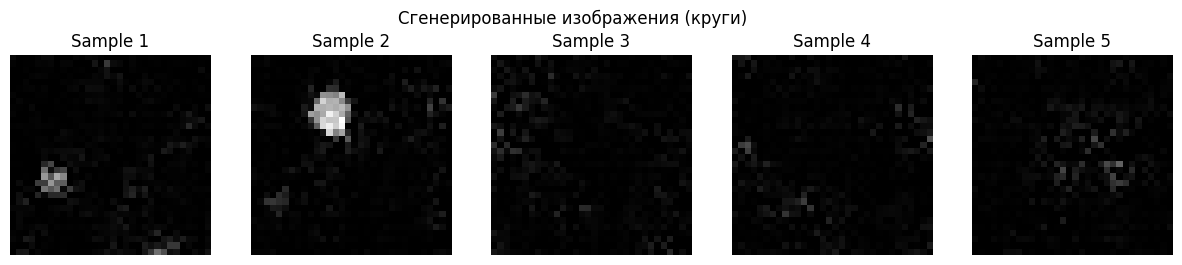

Готово! Результаты сохранены в папке 'results'.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

class SimpleUnet(nn.Module):
    """Упрощенный U-Net для предсказания шума."""
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(), # Downsample: 32->16
        )
        self.middle = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(), # Upsample: 16->32
            nn.Conv2d(16, 1, 3, padding=1),
        )

    def forward(self, x, t):
        return self.decoder(self.middle(self.encoder(x)))

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

def p_sample(model, x, t, alphas, alphas_cumprod, alphas_cumprod_prev, betas, t_index):
    with torch.no_grad():
        pred_noise = model(x, t)

        # Вычисляем восстановленное x_0
        sqrt_recip_alphas_cumprod_t = torch.sqrt(1.0 / alphas_cumprod[t]).view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod[t]).view(-1, 1, 1, 1)
        x_start = sqrt_recip_alphas_cumprod_t * (x - sqrt_one_minus_alphas_cumprod_t * pred_noise)

        alphas_cumprod_prev_t = alphas_cumprod_prev[t].view(-1, 1, 1, 1)
        betas_t = betas[t].view(-1, 1, 1, 1)
        alphas_t = alphas[t].view(-1, 1, 1, 1)

        posterior_mean_coef1 = betas_t * torch.sqrt(alphas_cumprod_prev_t) / (1.0 - alphas_cumprod[t]).view(-1, 1, 1, 1)
        posterior_mean_coef2 = (1.0 - alphas_cumprod_prev_t) * torch.sqrt(alphas_t) / (1.0 - alphas_cumprod[t]).view(-1, 1, 1, 1)
        posterior_mean = posterior_mean_coef1 * x_start + posterior_mean_coef2 * x

        posterior_variance_t = (betas[t] * (1.0 - alphas_cumprod_prev[t]) / (1.0 - alphas_cumprod[t])).view(-1, 1, 1, 1)

        noise = torch.randn_like(x) if t_index > 0 else torch.zeros_like(x)
        x_prev = posterior_mean + torch.sqrt(posterior_variance_t) * noise

        return x_prev

def main():
    timesteps = 100
    image_size = 32
    batch_size = 4
    epochs = 7000

    os.makedirs('results', exist_ok=True)

    def create_circle():
        img = np.zeros((image_size, image_size))
        center = image_size // 2
        radius = image_size // 4
        for i in range(image_size):
            for j in range(image_size):
                if (i - center)**2 + (j - center)**2 <= radius**2:
                    img[i, j] = 1.0
        return torch.tensor(img, dtype=torch.float32).view(1, 1, image_size, image_size)

    dataset = []
    for _ in range(100):
        img = np.zeros((image_size, image_size))
        center_offset = np.random.randint(-3, 4, size=2)
        radius_variation = np.random.randint(-2, 3)
        center = image_size // 2 + center_offset
        radius = image_size // 4 + radius_variation

        for i in range(image_size):
            for j in range(image_size):
                if (i - center[0])**2 + (j - center[1])**2 <= radius**2:
                    img[i, j] = 1.0
        dataset.append(torch.tensor(img, dtype=torch.float32).view(1, 1, image_size, image_size))

    dataset = torch.cat(dataset, dim=0)

    # 4.2 Инициализация расписания шума
    betas = linear_beta_schedule(timesteps)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    # 4.3 Инициализация модели и перемещение всех тензоров на устройство
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используется устройство: {device}")

    betas = betas.to(device)
    alphas = alphas.to(device)
    alphas_cumprod = alphas_cumprod.to(device)
    alphas_cumprod_prev = alphas_cumprod_prev.to(device)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

    model = SimpleUnet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("train")
    for epoch in range(epochs):
        indices = torch.randint(0, len(dataset), (batch_size,))
        x_start = dataset[indices].to(device)

        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        noise = torch.randn_like(x_start)
        x_noisy, true_noise = q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise)

        pred_noise = model(x_noisy, t)
        loss = F.mse_loss(pred_noise, true_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

    # 4.5 Генерация
    print("\nГенерация изображений...")
    model.eval()

    n_samples = 5
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))

    for idx in range(n_samples):
        x = torch.randn((1, 1, image_size, image_size), device=device)
        for i in reversed(range(timesteps)):
            t_tensor = torch.full((1,), i, device=device, dtype=torch.long)
            x = p_sample(model, x, t_tensor, alphas, alphas_cumprod,
                         alphas_cumprod_prev, betas, i)

        axes[idx].imshow(x.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[idx].set_title(f"Sample {idx+1}")
        axes[idx].axis('off')

    plt.suptitle("Сгенерированные изображения (круги)")
    plt.savefig('results/final_samples.png')
    plt.show()
    print("Готово! Результаты сохранены в папке 'results'.")

if __name__ == "__main__":
    main()

Используется устройство: cuda

Начало обучения...
Epoch 0/7000, Loss: 0.999924
Epoch 100/7000, Loss: 0.711225
Epoch 200/7000, Loss: 0.316317
Epoch 300/7000, Loss: 0.241163
Epoch 400/7000, Loss: 0.118796
Epoch 500/7000, Loss: 0.155089
Epoch 600/7000, Loss: 0.078580
Epoch 700/7000, Loss: 0.085925
Epoch 800/7000, Loss: 0.203227
Epoch 900/7000, Loss: 0.159126
Epoch 1000/7000, Loss: 0.112041
Epoch 1100/7000, Loss: 0.084254
Epoch 1200/7000, Loss: 0.106845
Epoch 1300/7000, Loss: 0.118326
Epoch 1400/7000, Loss: 0.076104
Epoch 1500/7000, Loss: 0.082306
Epoch 1600/7000, Loss: 0.089729
Epoch 1700/7000, Loss: 0.077037
Epoch 1800/7000, Loss: 0.121138
Epoch 1900/7000, Loss: 0.079600
Epoch 2000/7000, Loss: 0.071885
Epoch 2100/7000, Loss: 0.135638
Epoch 2200/7000, Loss: 0.116010
Epoch 2300/7000, Loss: 0.105150
Epoch 2400/7000, Loss: 0.142024
Epoch 2500/7000, Loss: 0.069694
Epoch 2600/7000, Loss: 0.067381
Epoch 2700/7000, Loss: 0.064681
Epoch 2800/7000, Loss: 0.089397
Epoch 2900/7000, Loss: 0.109533
Ep

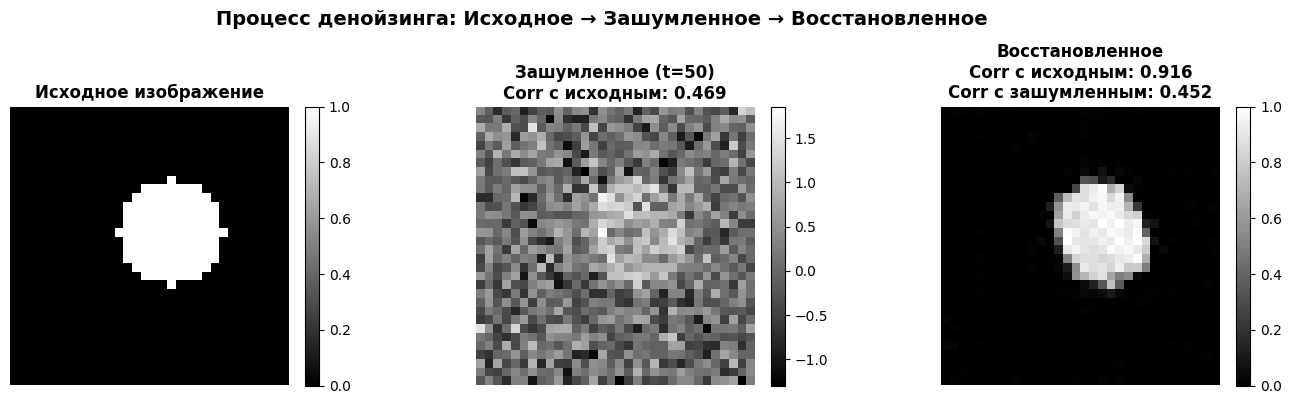

  Зашумленное vs Исходное:   0.4694
  Восстановленное vs Исходное: 0.9159
  Восстановленное vs Зашумленное: 0.4519

Генерация новых изображений...


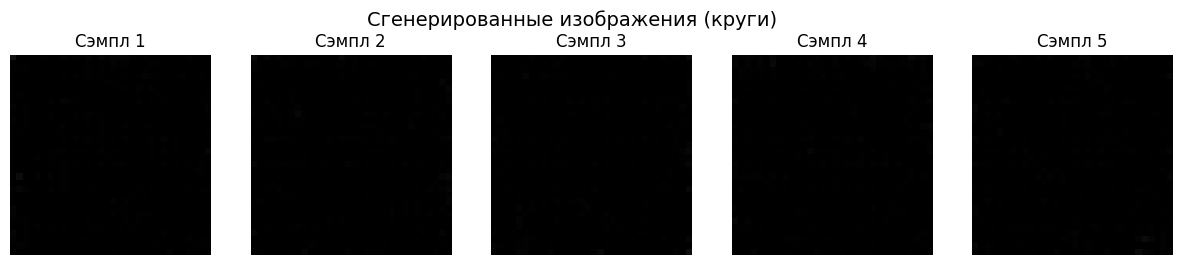

Готово! Результаты сохранены в папке 'results'.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

class SimpleUnet(nn.Module):
    """Улучшенный U-Net с временными вложениями."""
    def __init__(self, time_dim=32):
        super().__init__()
        # Модель для кодирования временной метки
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.ReLU(),
            nn.Linear(time_dim, time_dim),
        )

        # Кодировщик
        self.enc1 = nn.Conv2d(1, 16, 3, padding=1)
        self.enc2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)

        # Средний блок с учетом временной информации
        self.mid = nn.Sequential(
            nn.Conv2d(32 + time_dim, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
        )

        # Декодировщик
        self.dec1 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.dec2 = nn.Conv2d(16, 1, 3, padding=1)

    def forward(self, x, t):
        # Кодируем временную метку
        t_emb = self.time_mlp(t.float().unsqueeze(-1))  # [B, time_dim]
        t_emb = t_emb.view(t_emb.size(0), t_emb.size(1), 1, 1)

        # Прямой проход через кодировщик
        h = F.relu(self.enc1(x))  # [B, 16, 32, 32]
        h = F.relu(self.enc2(h))  # [B, 32, 16, 16]

        # КРИТИЧЕСКИ ВАЖНО: расширяем t_emb до размеров h, а не x!
        t_emb = t_emb.expand(-1, -1, h.size(2), h.size(3))  # [B, time_dim, 16, 16]

        # Добавляем временную информацию
        h = torch.cat([h, t_emb], dim=1)  # [B, 32+time_dim, 16, 16]
        h = self.mid(h)  # [B, 32, 16, 16]

        # Декодировщик
        h = F.relu(self.dec1(h))  # [B, 16, 32, 32]
        return self.dec2(h)  # [B, 1, 32, 32]

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise=None):
    """Прямой процесс диффузии: добавление шума."""
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

def p_sample(model, x, t, alphas, alphas_cumprod, alphas_cumprod_prev, betas, t_index):
    """Обратный процесс диффузии: удаление шума."""
    with torch.no_grad():
        pred_noise = model(x, t)

        # Извлекаем значения для текущего шага
        alphas_cumprod_t = alphas_cumprod[t].view(-1, 1, 1, 1)
        alphas_cumprod_prev_t = alphas_cumprod_prev[t].view(-1, 1, 1, 1)
        betas_t = betas[t].view(-1, 1, 1, 1)
        alphas_t = alphas[t].view(-1, 1, 1, 1)

        # Восстанавливаем x_0
        sqrt_recip_alphas_cumprod_t = torch.sqrt(1.0 / alphas_cumprod_t)
        sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod_t)
        x_start = sqrt_recip_alphas_cumprod_t * (x - sqrt_one_minus_alphas_cumprod_t * pred_noise)
        x_start = torch.clamp(x_start, -1, 1)

        # Вычисляем среднее значение апостериорного распределения
        posterior_mean_coef1 = betas_t * torch.sqrt(alphas_cumprod_prev_t) / (1.0 - alphas_cumprod_t)
        posterior_mean_coef2 = (1.0 - alphas_cumprod_prev_t) * torch.sqrt(alphas_t) / (1.0 - alphas_cumprod_t)
        posterior_mean = posterior_mean_coef1 * x_start + posterior_mean_coef2 * x

        # Вычисляем дисперсию апостериорного распределения
        posterior_variance = betas_t * (1.0 - alphas_cumprod_prev_t) / (1.0 - alphas_cumprod_t)

        # Сэмплируем из апостериорного распределения
        noise = torch.randn_like(x) if t_index > 0 else torch.zeros_like(x)
        x_prev = posterior_mean + torch.sqrt(posterior_variance) * noise

        return x_prev

def calculate_correlation(img1, img2):
    """Вычисляет коэффициент Пирсона между двумя изображениями."""
    flat1 = img1.cpu().numpy().flatten()
    flat2 = img2.cpu().numpy().flatten()
    return np.corrcoef(flat1, flat2)[0, 1]

def visualize_denoising_process(model, dataset, device, timesteps, sqrt_alphas_cumprod,
                                sqrt_one_minus_alphas_cumprod, alphas, alphas_cumprod,
                                alphas_cumprod_prev, betas, t_display=50):
    model.eval()

    # Выбираем случайное изображение из датасета
    idx = torch.randint(0, len(dataset), (1,)).item()
    original = dataset[idx:idx+1].to(device)

    # Добавляем шум на шаге t_display
    t_tensor = torch.full((1,), t_display, device=device, dtype=torch.long)
    noise = torch.randn_like(original)
    noisy, _ = q_sample(original, t_tensor, sqrt_alphas_cumprod,
                        sqrt_one_minus_alphas_cumprod, noise)

    # Восстанавливаем через полный обратный процесс
    x = noisy.clone()
    for i in reversed(range(timesteps)):
        t_step = torch.full((1,), i, device=device, dtype=torch.long)
        x = p_sample(model, x, t_step, alphas, alphas_cumprod,
                     alphas_cumprod_prev, betas, i)

    restored = x

    # Вычисляем корреляции
    corr_noisy_original = calculate_correlation(noisy, original)
    corr_restored_original = calculate_correlation(restored, original)
    corr_restored_noisy = calculate_correlation(restored, noisy)

    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    im0 = axes[0].imshow(original.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[0].set_title('Исходное изображение', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(noisy.cpu().squeeze(), cmap='gray')
    axes[1].set_title(f'Зашумленное (t={t_display})\nCorr с исходным: {corr_noisy_original:.3f}',
                      fontsize=12, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(restored.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[2].set_title(f'Восстановленное\nCorr с исходным: {corr_restored_original:.3f}\nCorr с зашумленным: {corr_restored_noisy:.3f}',
                      fontsize=12, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.suptitle('source -> noised-> reconstructed',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/denoising_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"  Зашумленное vs Исходное:   {corr_noisy_original:.4f}")
    print(f"  Восстановленное vs Исходное: {corr_restored_original:.4f}")
    print(f"  Восстановленное vs Зашумленное: {corr_restored_noisy:.4f}")

    return original, noisy, restored

def main():
    timesteps = 100
    image_size = 32
    batch_size = 8
    epochs = 7000

    os.makedirs('results', exist_ok=True)

    def create_circle():
        img = np.zeros((image_size, image_size))
        center = image_size // 2
        radius = image_size // 4
        for i in range(image_size):
            for j in range(image_size):
                if (i - center)**2 + (j - center)**2 <= radius**2:
                    img[i, j] = 1.0
        return torch.tensor(img, dtype=torch.float32).view(1, 1, image_size, image_size)

    # Генерация датасета с кругами
    dataset = []
    for _ in range(100):
        img = np.zeros((image_size, image_size))
        center_offset = np.random.randint(-3, 4, size=2)
        radius_variation = np.random.randint(-2, 3)
        center = image_size // 2 + center_offset
        radius = image_size // 4 + radius_variation

        for i in range(image_size):
            for j in range(image_size):
                if (i - center[0])**2 + (j - center[1])**2 <= radius**2:
                    img[i, j] = 1.0
        dataset.append(torch.tensor(img, dtype=torch.float32).view(1, 1, image_size, image_size))

    dataset = torch.cat(dataset, dim=0)

    # Инициализация расписания шума
    betas = linear_beta_schedule(timesteps)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    # Перемещение на устройство
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"device: {device}")

    betas = betas.to(device)
    alphas = alphas.to(device)
    alphas_cumprod = alphas_cumprod.to(device)
    alphas_cumprod_prev = alphas_cumprod_prev.to(device)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

    model = SimpleUnet(time_dim=32).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("\ntrain process")
    for epoch in range(epochs):
        indices = torch.randint(0, len(dataset), (batch_size,))
        x_start = dataset[indices].to(device)

        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        noise = torch.randn_like(x_start)
        x_noisy, true_noise = q_sample(x_start, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, noise)

        pred_noise = model(x_noisy, t)
        loss = F.mse_loss(pred_noise, true_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}")


    visualize_denoising_process(model, dataset, device, timesteps, sqrt_alphas_cumprod,
                                sqrt_one_minus_alphas_cumprod, alphas, alphas_cumprod,
                                alphas_cumprod_prev, betas, t_display=50)

    model.eval()

    n_samples = 5
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))

    for idx in range(n_samples):
        x = torch.randn((1, 1, image_size, image_size), device=device)
        for i in reversed(range(timesteps)):
            t_tensor = torch.full((1,), i, device=device, dtype=torch.long)
            x = p_sample(model, x, t_tensor, alphas, alphas_cumprod,
                         alphas_cumprod_prev, betas, i)

        axes[idx].imshow(x.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[idx].set_title(f"Сэмпл {idx+1}")
        axes[idx].axis('off')

    plt.suptitle("Сгенерированные изображения (круги)", fontsize=14)
    plt.savefig('results/final_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Готово! Результаты сохранены в папке 'results'.")

if __name__ == "__main__":
    main()

epoch     0 | loss 0.999456
epoch   500 | loss 0.056492
epoch  1000 | loss 0.082292
epoch  1500 | loss 0.103310
epoch  2000 | loss 0.043167
epoch  2500 | loss 0.058491
epoch  3000 | loss 0.031303
epoch  3500 | loss 0.034027
epoch  4000 | loss 0.040570
epoch  4500 | loss 0.024653
epoch  4999 | loss 0.039712
sampling step 150
sampling step 100
sampling step 50
sampling step 0


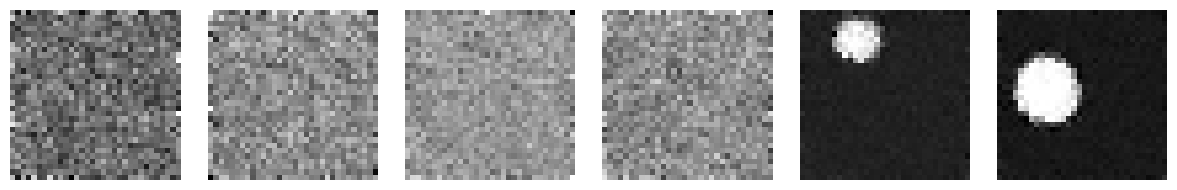

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt, os

class SimpleUnet(nn.Module):
    def __init__(self, time_dim=64):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, time_dim),
                                      nn.SiLU(),
                                      nn.Linear(time_dim, time_dim))

        self.enc1 = nn.Conv2d(1, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.enc3 = nn.Conv2d(64, 64, 3, stride=2, padding=1)

        self.mid = nn.Sequential(
            nn.Conv2d(64 + time_dim, 64, 3, padding=1), nn.SiLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.SiLU()
        )

        self.dec3 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.dec1 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t.float().unsqueeze(-1)).unsqueeze(-1).unsqueeze(-1)

        h1 = F.silu(self.enc1(x))
        h2 = F.silu(self.enc2(h1))
        h3 = F.silu(self.enc3(h2))

        h3 = torch.cat([h3, t_emb.expand(-1, -1, h3.size(2), h3.size(3))], dim=1)
        h3 = self.mid(h3)

        h = F.silu(self.dec3(h3)) + h2
        h = F.silu(self.dec2(h)) + h1
        return self.dec1(h)

def linear_beta_schedule(steps):
    return torch.linspace(0.0001, 0.02, steps)

def q_sample(x0, t, alphas_cumprod, noise):
    acp = alphas_cumprod[t].view(-1, 1, 1, 1)
    return torch.sqrt(acp) * x0 + torch.sqrt(1 - acp) * noise, noise

def p_sample(model, x, t, alphas, alphas_cumprod, alphas_cumprod_prev, betas, i):
    with torch.no_grad():
        pred_noise = model(x, t)
        alpha_t = alphas[t].view(-1, 1, 1, 1)
        alpha_cum_t = alphas_cumprod[t].view(-1, 1, 1, 1)
        alpha_cum_prev = alphas_cumprod_prev[t].view(-1, 1, 1, 1)
        beta_t = betas[t].view(-1, 1, 1, 1)

        x0 = (x - torch.sqrt(1 - alpha_cum_t) * pred_noise) / torch.sqrt(alpha_cum_t)
        x0 = torch.clamp(x0, -1., 1.)

        coef1 = beta_t * torch.sqrt(alpha_cum_prev) / (1 - alpha_cum_t)
        coef2 = (1 - alpha_cum_prev) * torch.sqrt(alpha_t) / (1 - alpha_cum_t)
        mean = coef1 * x0 + coef2 * x

        var = beta_t * (1 - alpha_cum_prev) / (1 - alpha_cum_t)
        noise = torch.randn_like(x) if i > 0 else 0
        return mean + torch.sqrt(var) * noise

def make_dataset(n, sz):
    data = []
    for _ in range(n):
        img = np.zeros((sz, sz), dtype=np.float32)
        cx = np.random.randint(sz//4, 3*sz//4)
        cy = np.random.randint(sz//4, 3*sz//4)
        r  = np.random.randint(sz//6, sz//4)
        Y, X = np.ogrid[:sz, :sz]
        mask = (X - cx)**2 + (Y - cy)**2 <= r**2
        img[mask] = 1.0
        data.append(img)
    return torch.tensor(np.stack(data)).unsqueeze(1)

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    os.makedirs('results', exist_ok=True)

    timesteps = 200
    img_size  = 32
    batch     = 16
    epochs    = 5000
    lr        = 2e-4

    ds = make_dataset(2000, img_size).to(device)
    betas  = linear_beta_schedule(timesteps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    model = SimpleUnet().to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        idx = torch.randint(0, len(ds), (batch,))
        x0 = ds[idx]
        t  = torch.randint(0, timesteps, (batch,), device=device)
        noise = torch.randn_like(x0)
        xt, _ = q_sample(x0, t, alphas_cumprod, noise)

        pred = model(xt, t)
        loss = F.mse_loss(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % 500 == 0 or epoch == epochs - 1:
            print(f'epoch {epoch:5d} | loss {loss.item():.6f}')

    model.eval()
    n_show = 6
    fig, ax = plt.subplots(1, n_show, figsize=(n_show*2, 2))
    with torch.no_grad():
        x = torch.randn(n_show, 1, img_size, img_size, device=device)
        for i in reversed(range(timesteps)):
            t_batch = torch.full((n_show,), i, device=device, dtype=torch.long)
            x = p_sample(model, x, t_batch, alphas, alphas_cumprod,
                         alphas_cumprod_prev, betas, i)
            if i % 50 == 0:
                print(f'sampling step {i}')
        x = (x + 1) / 2
        x = torch.clamp(x, 0, 1)
        for k in range(n_show):
            ax[k].imshow(x[k, 0].cpu(), cmap='gray')
            ax[k].axis('off')
    plt.tight_layout()
    plt.savefig('results/samples.png', dpi=150)
    plt.show()

if __name__ == '__main__':
    main()